In [29]:
import pandas as pd
from matplotlib import pyplot as plt
# pip install seaborn / conda install seaborn
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('../data/telecom_churn.csv')

In [3]:
df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})

In [4]:
df['Churn'] = df['Churn'].astype('int')

In [5]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [6]:
states = df.pop('State')

In [8]:
X,y = df.drop('Churn',axis=1), df['Churn']

In [11]:
X.shape, y.shape

((3333, 18), (3333,))

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = \
                train_test_split(X,y,test_size=0.3,random_state=17)

In [14]:
X_train.shape , X_test.shape

((2333, 18), (1000, 18))

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
dt = DecisionTreeClassifier(random_state=17)

**fit - predict**

In [17]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [18]:
from sklearn.metrics import accuracy_score

**Predictions for hold out set**

In [20]:
preds = dt.predict(X_test)

In [21]:
accuracy_score(y_test,preds)

0.921

**Baseline**

In [26]:
y.value_counts(normalize=True)

0    0.855086
1    0.144914
Name: Churn, dtype: float64

**Can we do better with hyper parameter tuning ?**

In [56]:
from sklearn.model_selection import StratifiedKFold,cross_val_score

In [60]:
from tqdm import tqdm_notebook

In [57]:
skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=17)

In [65]:
cv_accuracies_by_depth , test_accuracies_by_depth = [], []
max_depth_vals = np.arange(2,11)
# for each value of max_depth
for curr_max_depth in tqdm_notebook(max_depth_vals):
    tree = DecisionTreeClassifier(max_depth=curr_max_depth,random_state=17)
    # perform cross validation 
    val_scores = cross_val_score(tree,X=X_train,y=y_train,cv=skf)    
    cv_accuracies_by_depth.append(val_scores.mean())
    
    #assess model on test set
    tree.fit(X_train,y_train)
    curr_pred = tree.predict(X_test)
    test_accuracies_by_depth.append(accuracy_score(y_test,curr_pred))

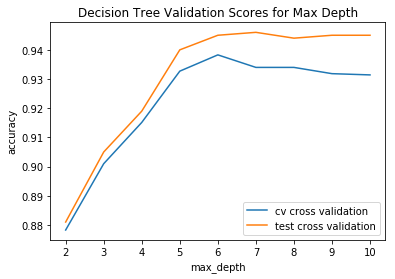

In [70]:
plt.plot(max_depth_vals,cv_accuracies_by_depth, label = 'cv cross validation')
plt.plot(max_depth_vals,test_accuracies_by_depth, label = 'test cross validation')
plt.legend();
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Decision Tree Validation Scores for Max Depth');

**Best Tree with Stratified K fold**

In [31]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [42]:
params = {'max_depth': np.arange(2,11) , 'min_samples_leaf': np.arange(1,11)}

In [43]:
skf = StratifiedKFold(n_splits=5 , shuffle=True, random_state=17)

In [44]:
best_tree = GridSearchCV(estimator=dt,param_grid=params ,scoring='accuracy', cv=skf,n_jobs=-1,
                        verbose=1)

In [45]:
%%time
best_tree.fit(X_train,y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    1.1s


Wall time: 2.41 s


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    2.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

 **Cross Validation Assessment of Model Quality**

In [54]:
best_tree.best_score_

0.9417059579939991

**Test Assessment**

In [55]:
preds_with_cv = best_tree.predict(X_test)
accuracy_score(y_test,preds_with_cv)

0.947